# Implementing Empirical CDFs for Precipitation Transformation

See Slater and Clark (2006)

In [7]:
# Import needed packages
import numpy as np
import pandas as pd
import xarray as xr

# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical packages
from scipy.stats import norm
from scipy.interpolate import interp1d

In [8]:
def calculate_monthly_cdfs(df):
    """
    Calculate the empirical cumulative distribution functions (CDFs) for each month and each station.

    This function computes the empirical CDF for the precipitation data of each station for each month,
    capturing the distribution of daily precipitation values over the years.

    :param df: DataFrame containing precipitation data, indexed by date, with columns as stations.
    :return: A nested dictionary where the top-level keys are station identifiers, and each value is another
             dictionary with months as keys (1 through 12) and the corresponding CDF data as values.
    """

    all_stations_cdfs = {}
    for station in df.columns:
        monthly_cdfs = {}
        for month in range(1, 13):
            # Extract data for the specific month and station, dropping missing values
            month_data = df[station][df.index.month == month].dropna()

            #Remove any zero or negative values
            month_data = month_data[month_data > 0]

            # Sort the data and calculate the empirical CDF values
            sorted_data = np.sort(month_data)
            cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

            # Store the CDF for this month and station
            monthly_cdfs[month] = pd.DataFrame({'Value': sorted_data, 'CDF': cdf_values})

        # Store the CDFs for all months for this station
        all_stations_cdfs[station] = monthly_cdfs

    return all_stations_cdfs

def normal_quantile_transform(df, all_stations_cdfs):
    """
    Apply a normal quantile transform to the precipitation data of each station for each month.

    This function matches the empirical cumulative probabilities of precipitation values
    with the cumulative probabilities from a standard normal distribution.

    :param df: DataFrame containing precipitation data, indexed by date, with columns as stations.
    :param all_stations_cdfs: Dictionary containing the empirical CDFs for each station and month.
    :return: DataFrame containing the Z-scores after transformation.
    """
    transformed_data = pd.DataFrame(index=df.index)

    for station in df.columns:
        if sum(df[station]) == 0:
            print(f'No precipitation data for station {station}, skipping station in normal_quantile_transform()')
            continue
        for month in range(1, 13):
            month_data = df[station][df.index.month == month]

            #Remove any zero or negative values
            month_data = month_data[month_data > 0]

            empirical_cdf = all_stations_cdfs[station][month]

            if empirical_cdf is not None and not empirical_cdf.empty:
                cdf_interp = interp1d(empirical_cdf['Value'], empirical_cdf['CDF'],bounds_error=False, fill_value="extrapolate")
                cum_probs = np.clip(cdf_interp(month_data.dropna()), 0, 1)
                z_scores = norm.ppf(cum_probs)
                transformed_data.loc[month_data.index, station] = z_scores
            else:
                transformed_data.loc[month_data.index, station] = np.nan
                #print(f'Missing data for empirical_cdf for station {station}, month {month}')

    return transformed_data

def inverse_normal_quantile_transform(transformed_data, all_stations_cdfs):
    """
    Reverse the normal quantile transform applied to the precipitation data.

    This function maps the Z-scores back to the original precipitation values using
    the empirical cumulative distribution functions (CDFs) for each station and month.

    :param transformed_data: DataFrame containing the Z-scores, indexed by date, with columns as stations.
    :param all_stations_cdfs: Dictionary containing the empirical CDFs for each station and month.
    :return: DataFrame containing the original precipitation values after reverse transformation.
    """
    back_transformed_data = pd.DataFrame(index=transformed_data.index)

    for station in transformed_data.columns:
        for month in range(1, 13):

            z_scores = transformed_data[station][transformed_data.index.month == month]

            empirical_cdf = all_stations_cdfs[station][month]

            if empirical_cdf is not None and not empirical_cdf.empty:

                cum_probs = norm.cdf(z_scores)
                value_interp = interp1d(empirical_cdf['CDF'], empirical_cdf['Value'], bounds_error=False, fill_value="extrapolate")

                original_values = value_interp(cum_probs)

                #Fill nan values with zero
                original_values = np.nan_to_num(original_values)

                back_transformed_data.loc[z_scores.index, station] = original_values
            else:
                # Handle empty or missing data appropriately (e.g., set to NaN)
                back_transformed_data.loc[z_scores.index, station] = np.nan

    back_transformed_data = back_transformed_data.T
    
    return back_transformed_data

def monthly_cdf_transform(data, time, cdfs):
    """
    Apply the normal quantile transform to the input precipitation data for each month.

    This function transforms the empirical distribution of monthly precipitation data
    to a standard normal distribution using the cumulative distribution function (CDF).

    Parameters:
    - data (array-like): 2D array of precipitation data with shape (nstn, ntime).
    - time (array-like): Array of dates corresponding to the precipitation data.

    Returns:
    - ndarray: Transformed data with Z-scores, shape (nstn, ntime).
    """
    df = pd.DataFrame(data=data, index=pd.to_datetime(time))

    transformed_df = normal_quantile_transform(df, cdfs)

    datat = transformed_df.to_numpy()

    return datat

def monthly_cdf_back_transform(data, time, cdfs):
    """
    Apply the inverse of the normal quantile transform to the input transformed data.

    This function reverts the transformed Z-scores back to the original precipitation values
    using the inverse of the empirical cumulative distribution function (CDF).

    Parameters:
    - data (array-like): 2D array of transformed data (Z-scores) with shape (nstn, ntime).
    - time (array-like): Array of dates corresponding to the transformed data.

    Returns:
    - ndarray: Original (reverted) precipitation data, shape (nstn, ntime).
    """
    if data.shape[0] != len(time):
        data = data.T

    df = pd.DataFrame(data=data, index=pd.to_datetime(time))

    back_transformed_df = inverse_normal_quantile_transform(df, cdfs)

    datat = back_transformed_df.to_numpy()

    return datat


In [9]:
# Example usage:
input_nc = '/Users/drc858/Data/gpep/data_prep/stations/input_stations_subset.nc'
stn_ds = xr.open_dataset(input_nc)

data = stn_ds['prcp'].values
date_array = stn_ds['date'].values

#Convert data array to pandas dataframe
time = pd.to_datetime(date_array, format='%Y%m%d')
df = pd.DataFrame(data.T, index=time)

# Calculate monthly empirical CDFs
cdfs = calculate_monthly_cdfs(df)

# Transform the data
transformed_data = monthly_cdf_transform(data.T, time, cdfs)

# Retransform the data
retransformed_data = monthly_cdf_back_transform(transformed_data.T,time,cdfs)

#Convert output to dataframes for visualization 
transformed_data_df = pd.DataFrame(data=transformed_data, index=time)
retransformed_data_df = pd.DataFrame(data=retransformed_data.T, index=time)

/Users/drc858/.pyenv/versions/3.9.16/envs/gpep/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/drc858/.pyenv/versions/3.9.16/envs/gpep/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


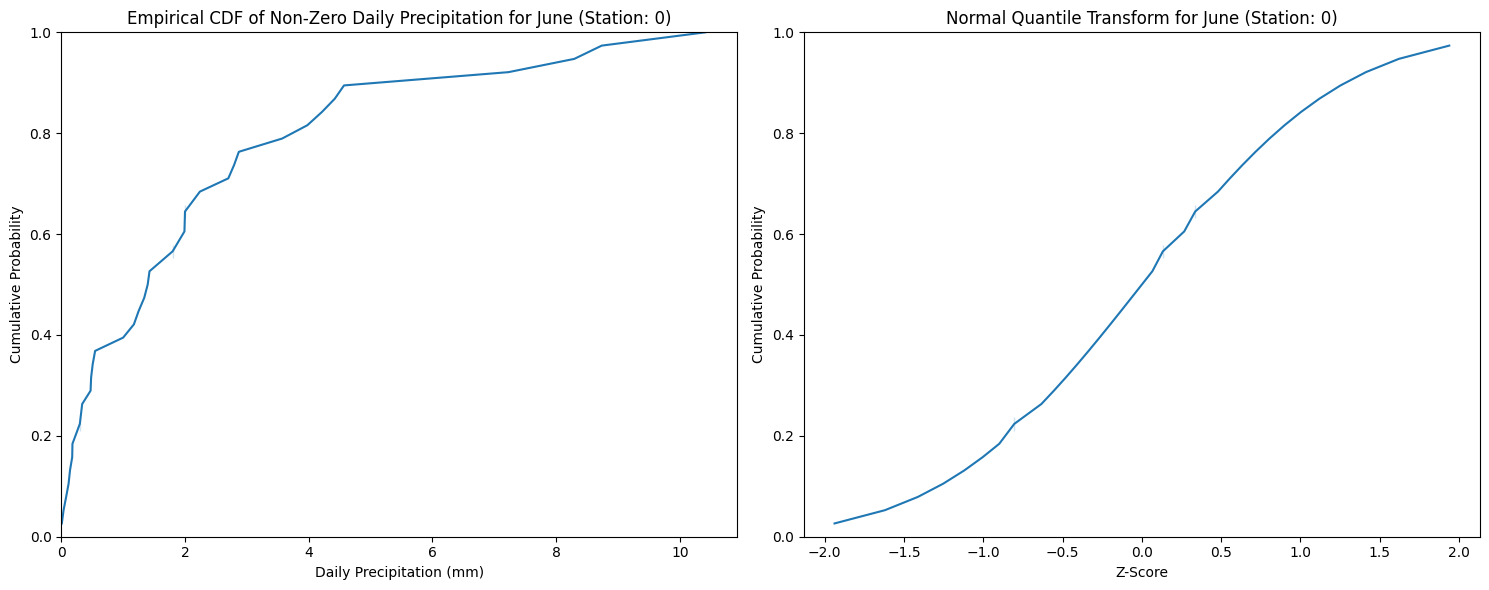

In [10]:
# Corrected function to plot the empirical CDF and the transformed data for a specified month and station
def plot_monthly_data(all_stations_cdfs, transformed_data, station, month):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Empirical CDF plot
    sns.lineplot(ax=axes[0], data=all_stations_cdfs[station][month], x='Value', y='CDF')
    axes[0].set_title(f'Empirical CDF of Non-Zero Daily Precipitation for {pd.to_datetime(month, format="%m").strftime("%B")} (Station: {station})')
    axes[0].set_xlabel('Daily Precipitation (mm)')
    axes[0].set_ylabel('Cumulative Probability')
    axes[0].set_ylim(0, 1)
    axes[0].set_xlim(0,)

    # Corrected Normal Quantile Transform plot
    month_data = transformed_data[station][time.month == month]
    month_data_sorted = np.sort(month_data.dropna())
    cdf = np.arange(1, len(month_data_sorted) + 1) / len(month_data_sorted)
    data_df = pd.DataFrame({'Z-Score': month_data_sorted, 'Cumulative Probability': cdf})
    sns.lineplot(ax=axes[1], data=data_df, x='Z-Score', y='Cumulative Probability')
    axes[1].set_title(f'Normal Quantile Transform for {pd.to_datetime(month, format="%m").strftime("%B")} (Station: {station})')
    axes[1].set_xlabel('Z-Score')
    axes[1].set_ylabel('Cumulative Probability')
    axes[1].set_ylim(0, 1) 

    plt.tight_layout()
    plt.show()

# Plot the corrected data 
station_index = 0
month_index = 6
plot_monthly_data(cdfs, transformed_data_df, station_index, month_index)

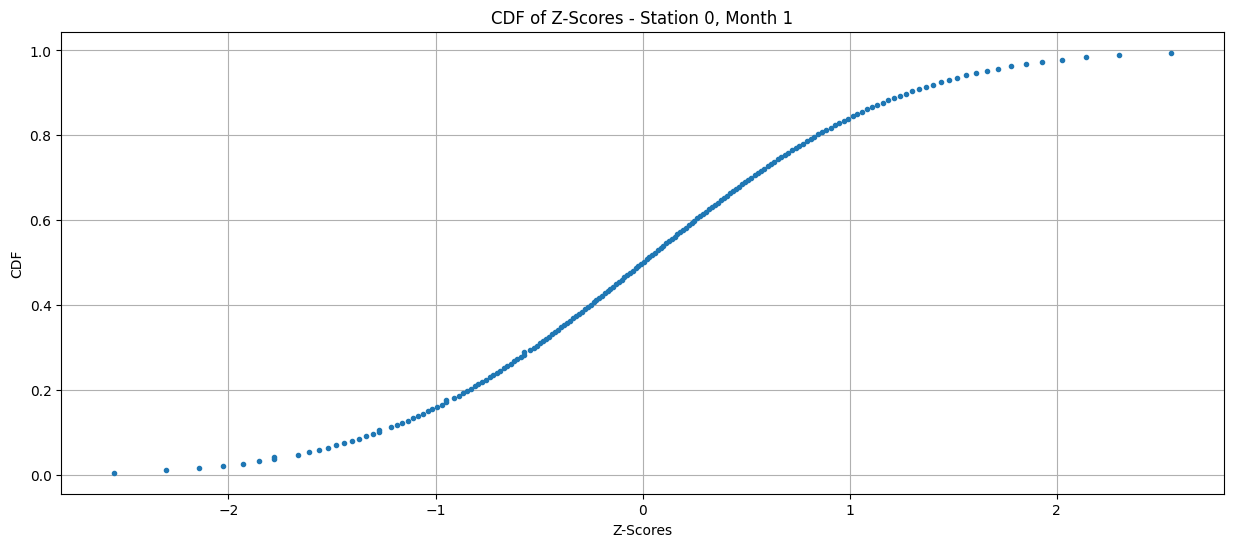

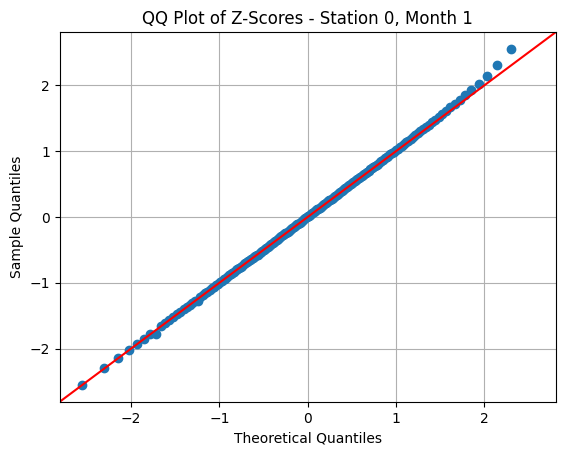

In [13]:

import statsmodels.api as sm
from scipy import stats

def plot_cdf_of_z_scores(transformed_data, station_index, month, time, title="CDF of Z-Scores"):
    """
    Plot the cumulative distribution function (CDF) of the Z-scores for a specific station and month.

    Parameters:
    - transformed_data (ndarray): 2D array of transformed data (Z-scores) with shape (nstn, ntime).
    - station_index (int): Index of the station.
    - month (int): Month number (1-12).
    - time (array-like): Array of dates corresponding to the transformed data.
    - title (str): Title of the plot.
    """
    # Convert time to datetime and filter for the specified month
    time = pd.to_datetime(time)
    station_data = transformed_data[station_index]
    month_data = station_data[time.month == month]

    # Remove NaN values and sort the data
    sorted_data = np.sort(month_data[~np.isnan(month_data)])

    # Calculate the CDF values
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Plotting
    plt.figure(figsize=(15, 6))
    #fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    plt.plot(sorted_data, cdf, marker='.', linestyle='none')
    plt.title(f"{title} - Station {station_index}, Month {month}")
    plt.xlabel("Z-Scores")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.show()

    
    sm.qqplot(sorted_data, line ='45',fit=False, dist=stats.norm) 
    plt.title(f"QQ Plot of Z-Scores - Station {station_index}, Month {month}")
    plt.grid(True)

plot_cdf_of_z_scores(transformed_data_df, 0, 1, time)

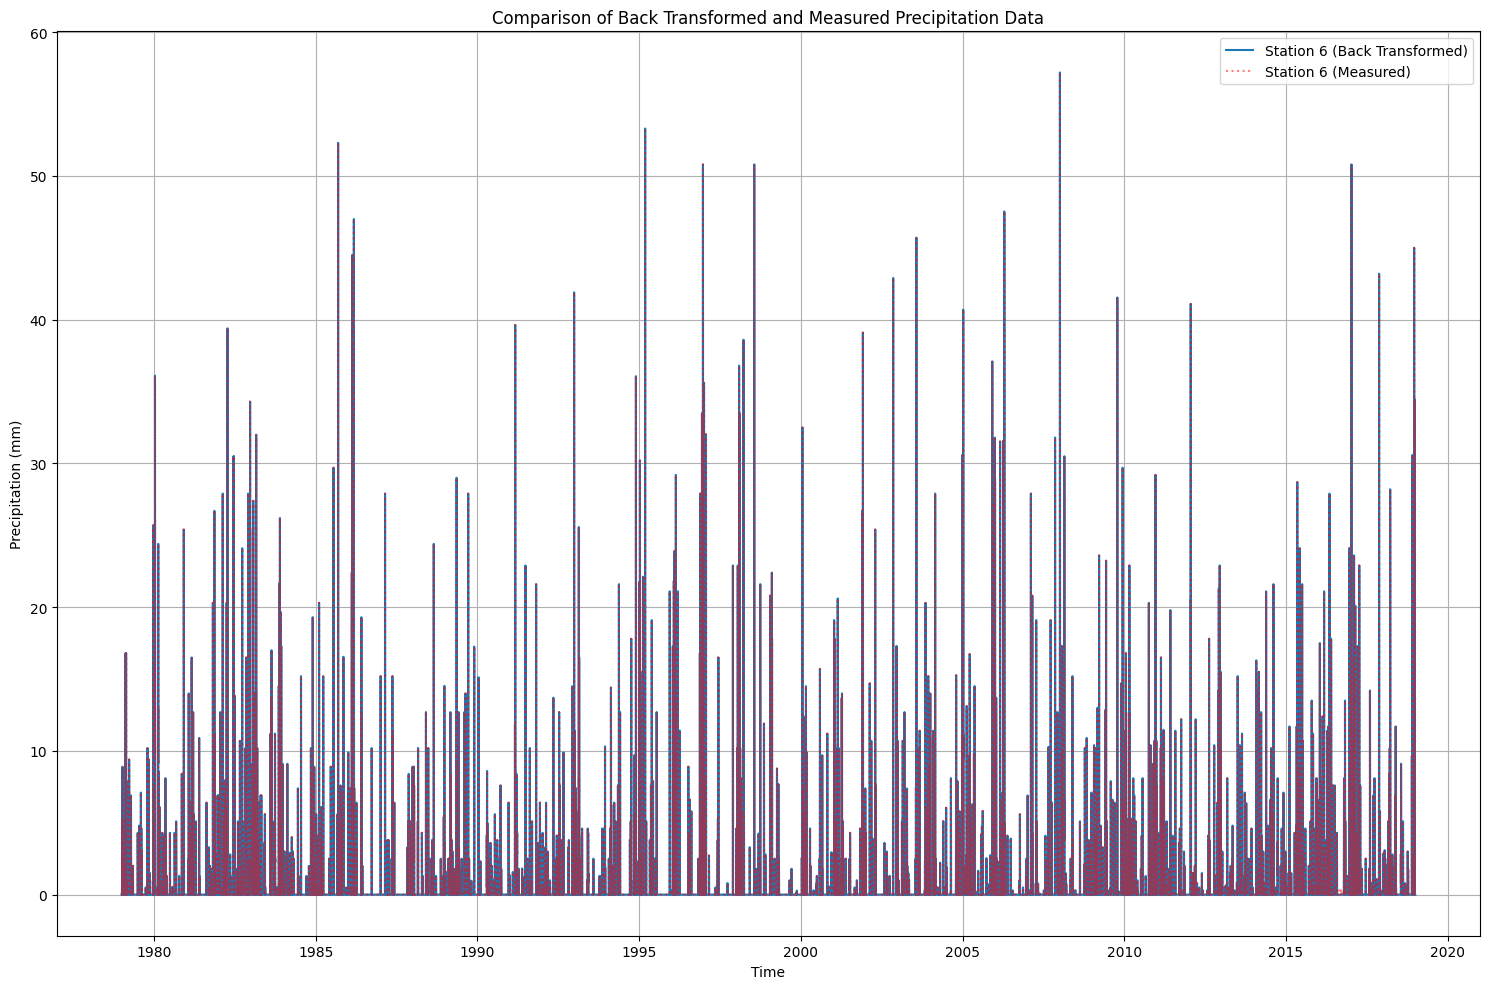

In [12]:
def plot_transformed_data(transformed_data, station_indices, time, title="Transformed Data Distribution"):
    """
    Plot the distribution of the transformed data (Z-scores) for selected stations.

    Parameters:
    - transformed_data (ndarray): 2D array of transformed data (Z-scores) with shape (nstn, ntime).
    - station_indices (list): List of indices representing the stations to be plotted.
    - time (array-like): Array of dates corresponding to the transformed data.
    - title (str): Title of the plot. Default is "Transformed Data Distribution".
    """
    plt.figure(figsize=(12, 6))

    for station_index in station_indices:
        plt.plot(pd.to_datetime(time), transformed_data[station_index], label=f"Station {station_index}")

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Precipitation (mm)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_transformed_and_measured_data(transformed_data, data, station_indices, time, title="Transformed and Measured Data Distribution"):
    """
    Plot the distribution of the transformed data (Z-scores) and the measured data for selected stations.

    Parameters:
    - transformed_data (ndarray): 2D array of transformed data (Z-scores) with shape (nstn, ntime).
    - stn_ds (Dataset): Dataset containing the station data.
    - data (ndarray): 2D array of measured data with shape (nstn, ntime).
    - station_indices (list): List of indices representing the stations to be plotted.
    - time (array-like): Array of dates corresponding to the transformed data.
    - title (str): Title of the plot. Default is "Transformed and Measured Data Distribution".
    """
    
    plt.figure(figsize=(15, 10))

    for station_index in station_indices:
        plt.plot(pd.to_datetime(time), transformed_data[station_index], label=f"Station {station_index} (Back Transformed)")
        plt.plot(pd.to_datetime(time), data[station_index], label=f"Station {station_index} (Measured)",color='red',linestyle='dotted',alpha=0.5)

        plt.title('Comparison of Back Transformed and Measured Precipitation Data')
        plt.xlabel("Time")
        plt.ylabel("Precipitation (mm)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

    plt.show()

measured_nc = '/Users/drc858/Data/gpep/data_prep/stations/input_stations_subset.nc'
measured_ds = xr.open_dataset(input_nc)
measured_precip = measured_ds['prcp']

#plot_transformed_data(retransformed_data, [6], time, "Transformed Precipitation Data")
station_list = [6]
plot_transformed_and_measured_data(retransformed_data, measured_precip, station_list, time, "Transformed and Measured Precipitation Data")


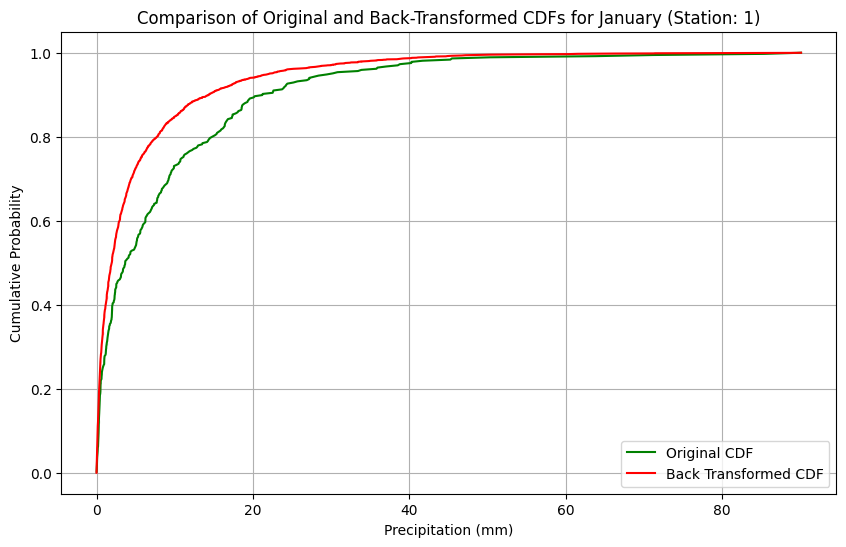

In [ ]:
# Function to plot both the original empirical CDF and the back-transformed data on the same plot for comparison
def plot_comparison_of_cdfs(all_stations_cdfs, back_transformed_data, station, month):
    plt.figure(figsize=(10, 6))

    # Original empirical CDF plot
    empirical_cdf = all_stations_cdfs[station][month]
    sns.lineplot(data=empirical_cdf, x='Value', y='CDF', label='Original CDF',color='green')

    # Back-transformed data plot
    #Pre-process transformed data to remove negative values
    back_transformed_data_station = back_transformed_data[station]
    back_transformed_data_station = back_transformed_data_station[back_transformed_data_station > 0]
    back_transformed_sorted = np.sort(back_transformed_data_station)

    #Calculate CDF values
    cdf_values_back_transformed = np.arange(1, len(back_transformed_sorted) + 1) / len(back_transformed_sorted)

    #Plot back-transformed data
    data_df = pd.DataFrame({'Back Transformed': back_transformed_sorted, 'Cumulative Probability': cdf_values_back_transformed})
    sns.lineplot(data=data_df, x='Back Transformed', y='Cumulative Probability', label='Back Transformed CDF',color='red')

    plt.title(f'Comparison of Original and Back-Transformed CDFs for {pd.to_datetime(month, format="%m").strftime("%B")} (Station: {station})')
    plt.xlabel('Precipitation (mm)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

station_index = 1
month_index = 1
plot_comparison_of_cdfs(cdfs, retransformed_data,station_index, month_index)

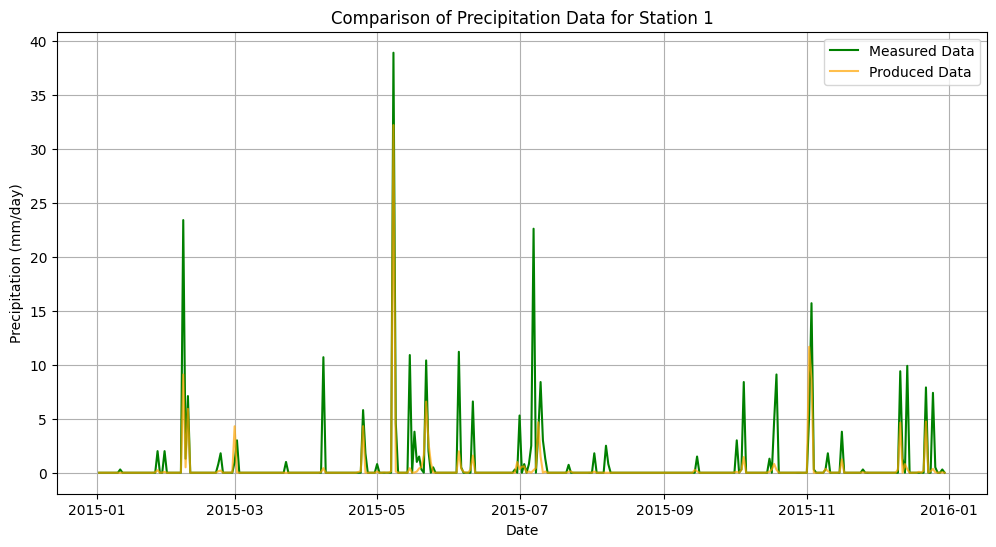

In [25]:
import xarray as xr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_precipitation(file_path_1, file_path_2, station_index, color_file_1='blue', color_file_2='red'):
    """
    Compare the precipitation data for a specified station from two NetCDF files.

    Parameters:
    file_path_1 (str): Path to the first NetCDF file.
    file_path_2 (str): Path to the second NetCDF file.
    station_index (int): Index of the station to analyze (0-based index).
    color_file_1 (str): Color for the plot line from File 1. Default is 'blue'.
    color_file_2 (str): Color for the plot line from File 2. Default is 'red'.
    """
    # Load the datasets
    data_1 = xr.open_dataset(file_path_1)
    data_2 = xr.open_dataset(file_path_2)

    # Extract precipitation data for the specified station from both datasets
    prcp_data_1_station = data_1['prcp'][station_index, :].values
    prcp_data_2_station = data_2['prcp'][station_index, :].values

    # Extract corresponding dates for the precipitation data
    dates_1 = data_1['date'].values if 'date' in data_1 else data_1['time'].values
    dates_2 = data_2['date'].values if 'date' in data_2 else data_2['time'].values

    # Convert dates from the first file to datetime format for consistency
    dates_1_datetime = pd.to_datetime(dates_1, format='%Y%m%d') if isinstance(dates_1[0], np.int32) else dates_1

    # Create DataFrames for the specified station
    df_prcp_1_station = pd.DataFrame({'Date': dates_1_datetime, 'Precipitation_File1': prcp_data_1_station})
    df_prcp_2_station = pd.DataFrame({'Date': dates_2, 'Precipitation_File2': prcp_data_2_station})

    # Merge the two dataframes on the date for the specified station
    df_prcp_merged_station = pd.merge(df_prcp_1_station, df_prcp_2_station, on='Date', how='inner')

    # Plotting the precipitation data for the specified station
    plt.figure(figsize=(12, 6))
    plt.plot(df_prcp_merged_station['Date'], df_prcp_merged_station['Precipitation_File1'], label='Measured Data', color=color_file_1)
    plt.plot(df_prcp_merged_station['Date'], df_prcp_merged_station['Precipitation_File2'], label='Produced Data', color=color_file_2, alpha=0.7)
    plt.title(f'Comparison of Precipitation Data for Station {station_index}')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm/day)')
    plt.legend()
    plt.grid(True)
    plt.show()

    data_1.close()
    data_2.close()

# Example usage of the function
all_stations_file = '/Users/drc858/Data/gpep/data_prep/stations/input_stations_subset.nc'
output_file = '/Users/drc858/Data/gpep/tuolumne_testing/regression/LWLRstatic_stn_CV_regression.nc'
compare_precipitation(all_stations_file, output_file, station_index=1, color_file_1='green', color_file_2='orange')
